# This plots the \Delta T over time
## Run from beginning until the end gives all the pictures

### Used for: 
- Full Figure
    - hom_P-2Pr (historic)
    - hom_P-2Pr_const
    - hom_P-2Pr_rev
        --> percentage of what's the dT after 50 years of no P_hum (2180)
- Half Figure 
    - hom_P-SSP5_opt1WB
    - hom_P--2Pr (until 2100)
        --> Also get numbers for sanity checks (dT(2010), dT(2126-2010, i.e. tenfold increase), dT/Phum)
    
#### Choose the options:
 - single
 - SSP5 (and opt)
 - historic
 - fut2250
 -!! runname !!
 
 REF is from 19.7.2018

    


In [42]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import gridspec
fs=20 #fontsize for labels, legend, ...
font={'family' : 'serif', 'size' : fs} #define font for legend
plt.rc('font', **font)
import cmocean
#from mpl_toolkits.basemap import Basemap
# import via conda install basemap (for some reason pip doesnt work)
from scipy.optimize import curve_fit


In [43]:
climber_path='/home/peter/PIK/climber/' #/home/peter/PIK/climber/
data_grid=xr.open_dataset(
    climber_path+'data_preparation/snapshots_potsdam2.055623.01.01.dta.nc', 
    decode_times=False)


In [44]:
Xcos,Ycos = np.meshgrid(data_grid.xt_i, np.cos(data_grid.yt_j*np.pi/180))
print(np.shape(data_grid.xt_i))
np.shape(Ycos)

(16,)


(24, 16)

In [45]:
def get_time(y):
    return (y+54783-1-1810)*360-0.5
def get_year(t):
    return (t+0.5)/360 +1810+1-54783
    #return (t+54783-1-1810)*360-0.5
get_time(2010)
get_year(19793519.5)


2010.0

In [46]:
%%bash -s "$climber_path"
ls $1/cluster_results/data_Mai8files

c3beta_anthrHeat_hom_ampl_C
c3beta_anthrHeat_hom_ampl_CP
c3beta_anthrHeat_hom_P-2Pr
c3beta_anthrHeat_hom_P-2Pr_const
c3beta_anthrHeat_hom_P-2Pr_furthergrowth
c3beta_anthrHeat_hom_P-2Pr_furthergrowth_equ
c3beta_anthrHeat_hom_P-2Pr_rev
c3beta_anthrHeat_hom_P-SSP5_opt1WB
c3beta_anthrHeat_hom_P-SSP5_opt2direct
c3beta_anthrHeat_hom_REF
c3beta_anthrHeat_hom_REF_beyond2250
c3beta_anthrHeat_hom_REF_P2010_equ
c3beta_anthrHeat_hom_singleAM
c3beta_anthrHeat_hom_singleAU
c3beta_anthrHeat_hom_singleEU
c3beta_anthrHeat_hom_singleSH
c3beta_anthrHeat_hom_singleVA
download_files
new_relevant_files_CLUSTER
relevant_files_CLUSTER
relevant_files_CLUSTER_old
shorten_all_ncs


In [48]:
def run(runname, refname):
    data_ref= xr.open_dataset(folder_ref+"history_p2_short.nc", decode_times=False)
    data_p= xr.open_dataset(folder_p+"history_p2_short.nc", decode_times=False)
    if SSP:
        growth="SSP5-opt"+opt+ "-scenario"
    else:
        growth="2%-growth"
    if today:
        title_name="Temperature impact of historic data until 2010"
        #plot_name="T_"+runname+"_2010"
    else:
        title_name="Temperature impact of historic data and "+growth+" of $P_{hum}$ after 2010"+'\n'+"using "+runname+" and "+refname
        #plot_name="T_"+runname
    if fut2250:
        title_name="Temperature impact of "+growth+" of $P_{hum}$ until 2130 "+'\n'+"using "+runname+" and "+refname   

    if today:
        maxyear=2010
    elif fut2250:
        maxyear=get_year(max(data_p.Time))
        #maxyear=2250
    elif SSP:
        maxyear=2100
    else:
        maxyear=get_year(max(data_p.Time))
        #maxyear=2130
    double_years=np.arange(1900, maxyear+1, step=1)
    diff=np.empty([len(data_grid.yt_j), len(data_grid.xt_i), len(double_years)])
    ref_mean=[]
    p_mean=[]
    for n,y in enumerate(double_years):
        ref_mean.append(area_mean_lon(data_ref.ts_ann.sel(Time=get_time(y))))
        p_mean.append(area_mean_lon(data_p.ts_ann.sel(Time=get_time(y))))

        diff_y= data_p.ts_ann.sel(Time=get_time(y))-data_ref.ts_ann.sel(Time=get_time(y))
        for i in range(0,len(data_grid.xt_i)):
            for j in range(0,len(data_grid.yt_j)):
                diff[j,i, n]=(diff_y[j,i])
    print(np.shape(diff))
    difference=np.array(p_mean)-np.array(ref_mean)
    
    
    #return difference, double_years, std_dev_neg, std_dev_pos, p_mean, ref_mean, popt_hist, popt
    return difference, double_years, p_mean, ref_mean, diff
    

In [67]:
def plot_full(difference, double_years, p_mean, ref_mean, diff, totalTemp=True):
   
    if fut2250:
        popt, pcov= curve_fit(exp_growth, double_years[np.where(double_years==2010)[0][0]:np.where(double_years==2130)[0][0]], 
                              difference[np.where(double_years==2010)[0][0]:np.where(double_years==2130)[0][0]], 
                              bounds= ([0,0], [1,1]))
        popt_hist=0
    else:
        popt, pcov= curve_fit(exp_growth, double_years[np.where(double_years==2010)[0][0]:], 
                              difference[np.where(double_years==2010)[0][0]:], bounds= ([0,0], [1,1]))
        popt_hist, pcov_hist= curve_fit(exp_growth, double_years[:np.where(double_years==2010)[0][0]], 
                              difference[:np.where(double_years==2010)[0][0]], bounds= ([0,0], [1,1]))
        #popt2, pcov2= curve_fit(growth23, double_years[:], delta[:], bounds= ([0,0], [1,1]))
    #print(popt2)
    print(popt, popt_hist)
    
    
    if totalTemp:
        fig=plt.figure(figsize=(16,9))
        gs=gridspec.GridSpec(2,1,height_ratios=[3,1])
        ax=fig.add_subplot(gs[0])
    else:
        fig=plt.figure(figsize=(16,27./4))
        ax=fig.add_subplot(111)
    
    for i in range(0, len(data_grid.xt_i)):
        for j in range(0, len(data_grid.yt_j)):
            current_alpha=0.05+0.8*np.cos(data_grid.yt_j[j].values*np.pi/180)
            current_lw=0.5+1*np.cos(data_grid.yt_j[j].values*np.pi/180)
            plt.plot(double_years, diff[j,i,:], '-', color='lightgrey', alpha=current_alpha, lw=current_lw)
    
    ax.plot(double_years,difference, lw=8, color="blue",
            label=r"$\overline{\Delta T} = \overline{T_{P_{\rm hum}}}-\overline{T_{\rm ref}}$")
    ax.axhline(0, color='black')
                
    if SSP or today:
        ax.plot(double_years[:np.where(double_years==2010)[0][0]], 
            exp_growth(double_years[:np.where(double_years==2010)[0][0]],*popt_hist),
            '--', lw=6, color="darkorange", 
            label=r"exp Fit (historic): ${:.3f}^{} \cdot {:.3f}$".format((1+popt_hist[0]),r"{\,yr-2010}",  popt_hist[1])+r'$ \, {\rm K}$')
    elif fut2250:
        ax.plot(double_years[np.where(double_years==2010)[0][0]:np.where(double_years==2130)[0][0]], 
            exp_growth(double_years[np.where(double_years==2010)[0][0]:np.where(double_years==2130)[0][0]],*popt),
            '--', lw=6, color="limegreen", 
            label=r"exp Fit (future): ${:.3f}^{} \cdot {:.3f}$".format((1+popt[0]),r"{\,yr-2010}",  popt[1])+r'$ \, {\rm K}$')
    #ax.plot(double_years, growth23(double_years,*popt2), '--', lw=3, color="cyan")#, 
    #        #label="exp Fit: {1.023}^(yr-2010) *{:.1E}".format((1+popt2)))
    else:
        ax.plot(double_years[:np.where(double_years==2010)[0][0]], 
                exp_growth(double_years[:np.where(double_years==2010)[0][0]],*popt_hist),
                '--', lw=6, color="darkorange", 
                label=r"exp Fit (historic): ${:.3f}^{} \cdot {:.3f}$".format((1+popt_hist[0]),r"{\,yr-2010}",  popt_hist[1])+r'$ \, {\rm K}$')
        ax.plot(double_years[np.where(double_years==2010)[0][0]:], 
                exp_growth(double_years[np.where(double_years==2010)[0][0]:],*popt),
                '--', lw=6, color="limegreen", 
                label=r"exp Fit (future): ${:.3f}^{} \cdot {:.3f}$".format((1+popt[0]),r"{\,yr-2010}",  popt[1])+r'$ \, {\rm K}$')
        #ax.plot(double_years, growth23(double_years,*popt2), '--', lw=3, color="cyan")#, 
        #        #label="exp Fit: {1.023}^(yr-2010) *{:.1E}".format((1+popt2)))
    
    ax.set_ylabel(r"$\overline{\Delta T}\, [{\rm K}]$")
    ax.grid()
    ax.set_xticklabels([])
    ax.legend(fontsize=18, loc='upper left')
    if totalTemp:
        ax2=fig.add_subplot(gs[1])
        ax2.plot(double_years,p_mean, label=r'$\overline{T_{P_{\rm hum}}}$', color="red", lw=4)
        ax2.plot(double_years,ref_mean,  label=r'$\overline{T_{\rm ref}}$',color="lime", lw=2)
        ax2.set_xlabel("Years")
        ax2.legend(fontsize=18, loc='upper left')
        ax2.set_ylabel(r"$\overline{T} \, [{\rm ^\circ C}]$")
        ax2.grid()
    if today:
        ax.set_ylim(-0.01, 0.06)#0.13)
    elif fut2250:
        ax.set_ylim(-0.02, 0.25)
        if runname=="hom_P-2Pr_furthergrowth": ax.set_ylim(-0.02, 1.4)
    else:
        ax.set_ylim(-0.01, 0.18)
        #ax.set_xlim(1899,2101)
        #ax2.set_xlim(1899,2101)

    #ax.set_title(title_name)
    fig.tight_layout()
    #fig.savefig("T_historicP_third_third.png")
    print("will be saved as: ",plot_name)
    if totalTemp==False:
        fig.savefig(plot_name+"_onlydT.png", format='png', bbox_inches='tight')
        return 
    else:
        fig.savefig(plot_name+".png", format='png', bbox_inches='tight')
        return popt, popt_hist


In [62]:

def plot_smaller(difference, double_years, diff):
    popt, pcov= curve_fit(exp_growth, double_years[np.where(double_years==2010)[0][0]:], 
                              difference[np.where(double_years==2010)[0][0]:], bounds= ([0,0], [1,1]))
    popt_hist, pcov_hist= curve_fit(exp_growth, double_years[:np.where(double_years==2010)[0][0]], 
                              difference[:np.where(double_years==2010)[0][0]], bounds= ([0,0], [1,1]))
        #popt2, pcov2= curve_fit(growth23, double_years[:], delta[:], bounds= ([0,0], [1,1]))
    #print(popt2)
    print(popt, popt_hist)
    
    fig=plt.figure(figsize=(8,5))
    #gs=gridspec.GridSpec(2,1,height_ratios=[3,1])
    #ax=fig.add_subplot(gs[0])
    ax=fig.add_subplot(111)
    ax.plot(double_years,difference, lw=6, color="blue",
            label=r"$\overline{\Delta T} = \overline{T_{P_{\rm hum}}}-\overline{T_{\rm ref}}$")
    #ax.plot(double_years, smoothed_delta, '--k', label='smoothed $\Delta T$')
    ax.axhline(0, color='black')
    #ax.fill_between(double_years, difference-std_dev_neg, difference+std_dev_pos, alpha=0.5, color='lightgray',
    #                label="standard deviation") 
    #separately \n  for cells with $\Delta T_{cell}<\overline{\Delta T}$ and "+\
    #                "$\Delta T_{cell}>\overline{\Delta T}$")
    if SSP or today:
        ax.plot(double_years[:np.where(double_years==2010)[0][0]], 
            exp_growth(double_years[:np.where(double_years==2010)[0][0]],*popt_hist),
            '--', lw=6, color="darkorange")
            #label="exp Fit (historic): ${:.4f}^{} \cdot {:.3f} \, K$".format((1+popt_hist[0]),r"{\,yr-2010}",  popt_hist[1]))
    else:
        ax.plot(double_years[:np.where(double_years==2010)[0][0]], 
                exp_growth(double_years[:np.where(double_years==2010)[0][0]],*popt_hist),
                '--', lw=6, color="darkorange")
        ax.plot(double_years[np.where(double_years==2010)[0][0]:], 
                exp_growth(double_years[np.where(double_years==2010)[0][0]:],*popt),
                '--', lw=6, color="limegreen", 
                label=r"exp Fit (future):"+"\n"+
                "${:.3f}^{} \cdot {:.3f}$".format((1+popt[0]),r"{\,yr-2010}",popt[1])+r'$ \, {\rm K}$')
        #ax.plot(double_years, growth23(double_years,*popt2), '--', lw=3, color="cyan")#, 
        #        #label="exp Fit: {1.023}^(yr-2010) *{:.1E}".format((1+popt2)))


    ax.set_ylabel(r"$\overline{\Delta T}\, [{\rm K}]$")
    ax.grid()
    ax.legend(fontsize=18, loc='upper left')
    if today:
        ax.set_ylim(-0.01, 0.06)#0.13)
    elif fut2250:
        ax.set_ylim(-0.02, 0.25)
        if runname=="hom_P-2Pr_furthergrowth": ax.set_ylim(-0.02, 1.4)
    else:
        ax.set_ylim(-0.01, 0.1)
        ax.set_xlim(1899,2101)


    #ax.set_title(title_name)
    fig.tight_layout()
    print(plot_name+"_halfSize.png")
    #fig.savefig("T_historicP_third_third.png")
    fig.savefig(plot_name+"_halfSize.png", format='png', bbox_inches='tight')
    return

In [63]:
def exp_growth(x,a,b):
    return (1+a)**(x-2010)*b

In [64]:
def area_mean_lon(x, lats=data_grid.yt_j, lon=data_grid.xt_i):
    '''x should have dimensions: lat,lon'''
    weights=np.cos(lats*np.pi/180)
    irrelevant,real_weights=np.meshgrid(lon, weights)
    z=real_weights*x
    return np.sum(z)/np.sum(real_weights)

In [65]:
def get_sanity_checks( difference, popt, popt_hist, double_years):
    if today: print("That means:", popt_hist[1]/0.034, " K T-change per W/m^2 P_hum")
    print("That means:", popt[1]/0.034, " K T-change per W/m^2 P_hum")
    # Sanity checks
    print("2010:", difference[np.where(double_years==2010)] )
    print("2010-2126:", difference[np.where(double_years==2126)]-difference[np.where(double_years==2010)] )
    print("in year 2126: ", difference[np.where(double_years==2126)])
    if fut2250: difference[np.where(double_years==2180)] / difference[np.where(double_years==2130)]
    if fut2250: difference[np.where(double_years==2250)]-difference[np.where(double_years==2010)]
    return 

# MAIN PART

In [66]:
mainfolder=climber_path+"cluster_results/data_Mai8files/"
reffolder=mainfolder
single=False
SSP=False
fut2250=False
today=False

refname="hom_REF"#"RESTandREF_fourth_sol2"#"RESTandREF_fourth"

folder_ref=reffolder+"c3beta_anthrHeat_"+refname+'/'

## Phum -2Pr bis 2100

In [60]:
opt=""
runname="hom_P-2Pr"
single=False
SSP=False
fut2250=False
today=False
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
difference, double_years, p_mean, ref_mean, diff = run(refname, runname)



(24, 16, 231)
('That means:', 0.5025085749497269, ' K T-change per W/m^2 P_hum')
('2010:', array([0.01708529]))
('2010-2126:', array([0.12658085]))
('in year 2126: ', array([0.14366614]))


(array([0.02002434, 0.01445107]), array([0.01701529, 0.01560085]))
('will be saved as: ', 'T(t)_hom_P-2Pr')
('That means:', 0.42503157534442854, ' K T-change per W/m^2 P_hum')
('2010:', array([0.01708529]))
('2010-2126:', array([0.12658085]))
('in year 2126: ', array([0.14366614]))
(array([0.02002434, 0.01445107]), array([0.01701529, 0.01560085]))
('will be saved as: ', 'T(t)_hom_P-2Pr')
(array([0.02002434, 0.01445107]), array([0.01701529, 0.01560085]))
T(t)_hom_P-2Pr_halfSize.png


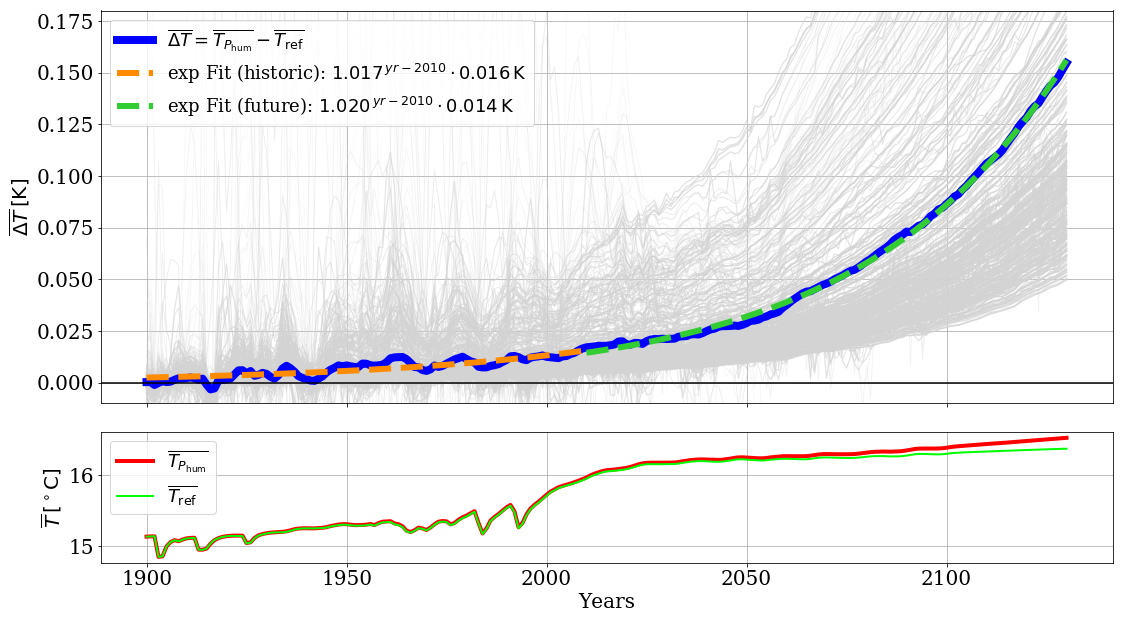

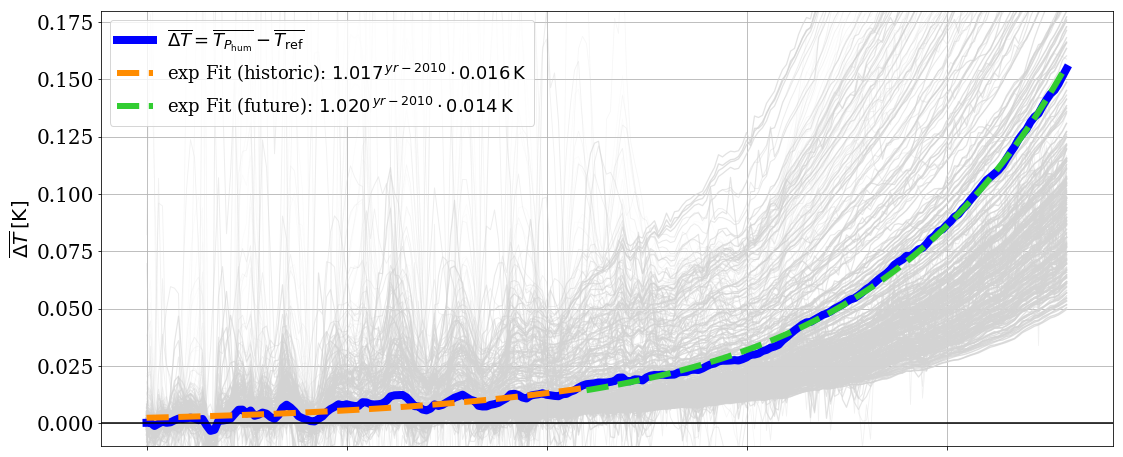

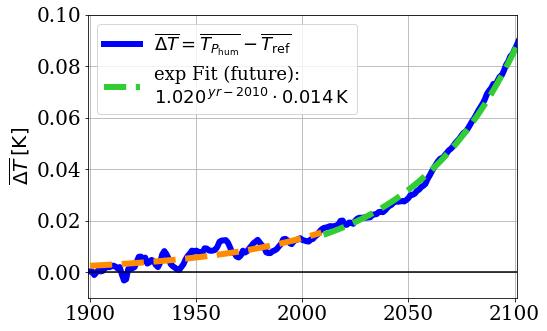

In [68]:
plot_name="T(t)_"+runname
popt, popt_hist = plot_full(difference, double_years, p_mean, ref_mean, diff)
get_sanity_checks(difference, popt, popt_hist, double_years)
plot_full(difference, double_years, p_mean, ref_mean,  diff, totalTemp=False)
plot_smaller(difference, double_years, diff)

# P Hum historic

In [39]:
opt=""
#runname="hom_P-SSP5_opt"+opt
runname="hom_P-2Pr"
single=False
SSP=False
fut2250=False
today=True
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
  
difference, double_years, p_mean, ref_mean, popt_hist, popt, diff = run(refname, runname)
   
get_sanity_checks(difference, popt, popt_hist, double_years)

(24, 16, 111)
(array([0.5       , 0.01708529]), array([0.01701529, 0.01560085]))
('That means:', 0.45884844271804115, ' K T-change per W/m^2 P_hum')
('That means:', 0.5025085749497269, ' K T-change per W/m^2 P_hum')
('2010:', array([0.01708529]))
('2010-2126:', array([], dtype=float64))
('in year 2126: ', array([], dtype=float64))


/home/peter/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


('will be saved as: ', 'T(t)_hom_P-2Pr_historic')
('will be saved as: ', 'T(t)_hom_P-2Pr_historic')
T(t)_hom_P-2Pr_historic_halfSize.png


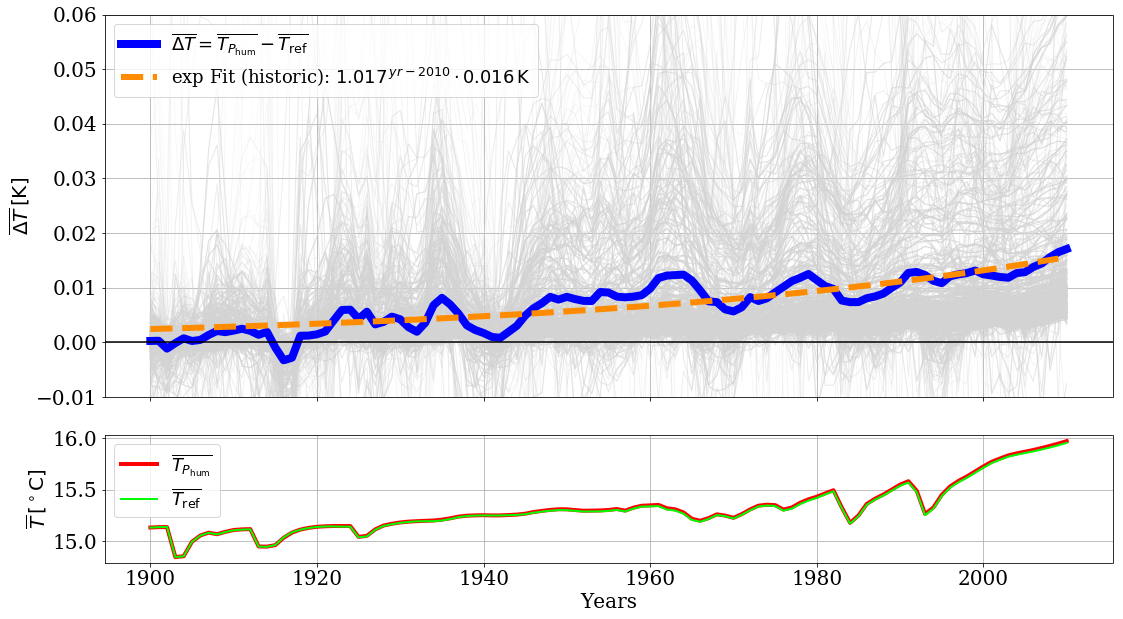

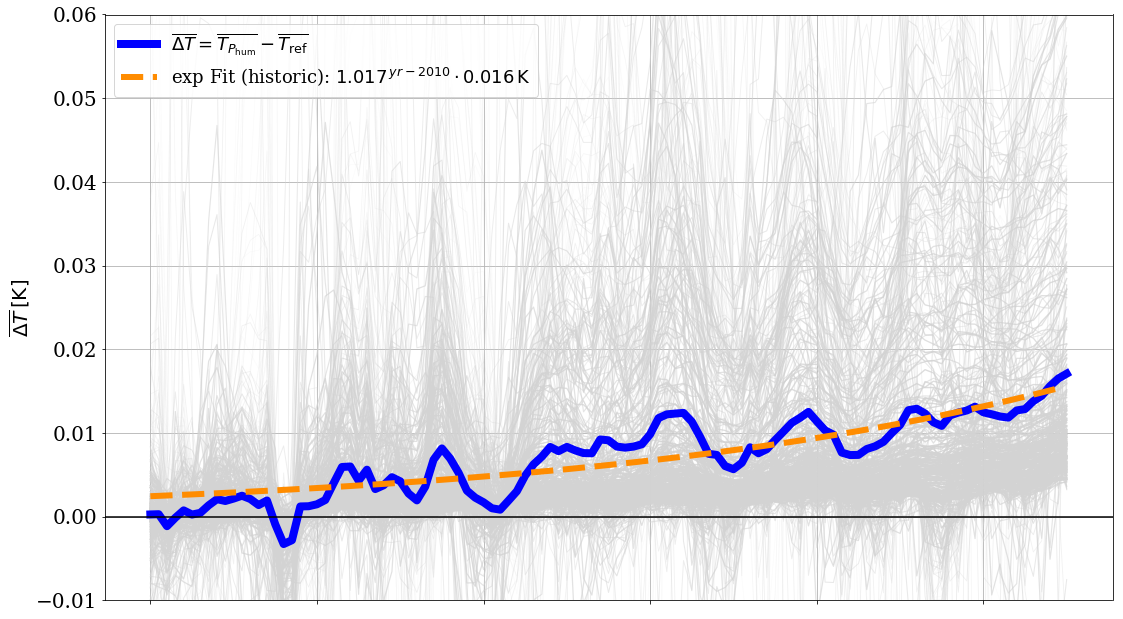

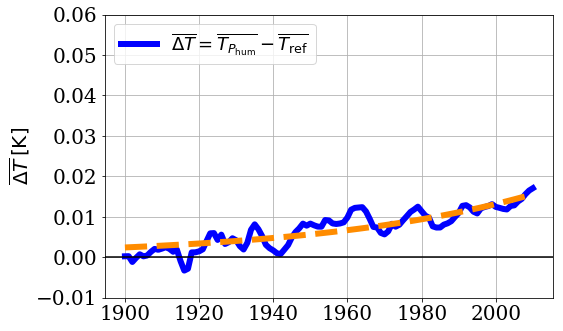

In [77]:
plot_name="T(t)_"+runname+"_historic"
plot_full(difference, double_years, p_mean, ref_mean, popt_hist, popt, diff)
plot_full(difference, double_years, p_mean, ref_mean, popt_hist, popt, diff, totalTemp=False)
plot_smaller(difference, double_years, popt_hist, popt, diff)

# SSP

In [ ]:
opt="1WB"
runname="hom_P-SSP5_opt"+opt
single=False
SSP=True
fut2250=False
today=False
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
difference, double_years, p_mean, ref_mean, popt_hist, popt, diff= run(refname, runname)


('will be saved as: ', 'T(t)_hom_P-SSP5_opt1WB')
('will be saved as: ', 'T(t)_hom_P-SSP5_opt1WB')
T(t)_hom_P-SSP5_opt1WB_halfSize.png


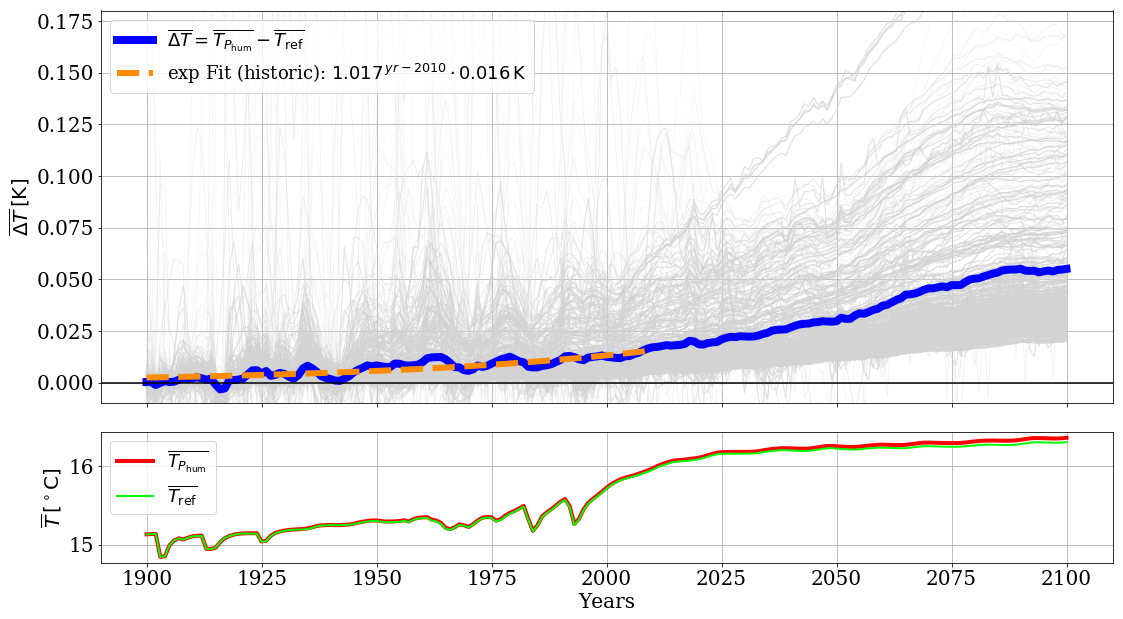

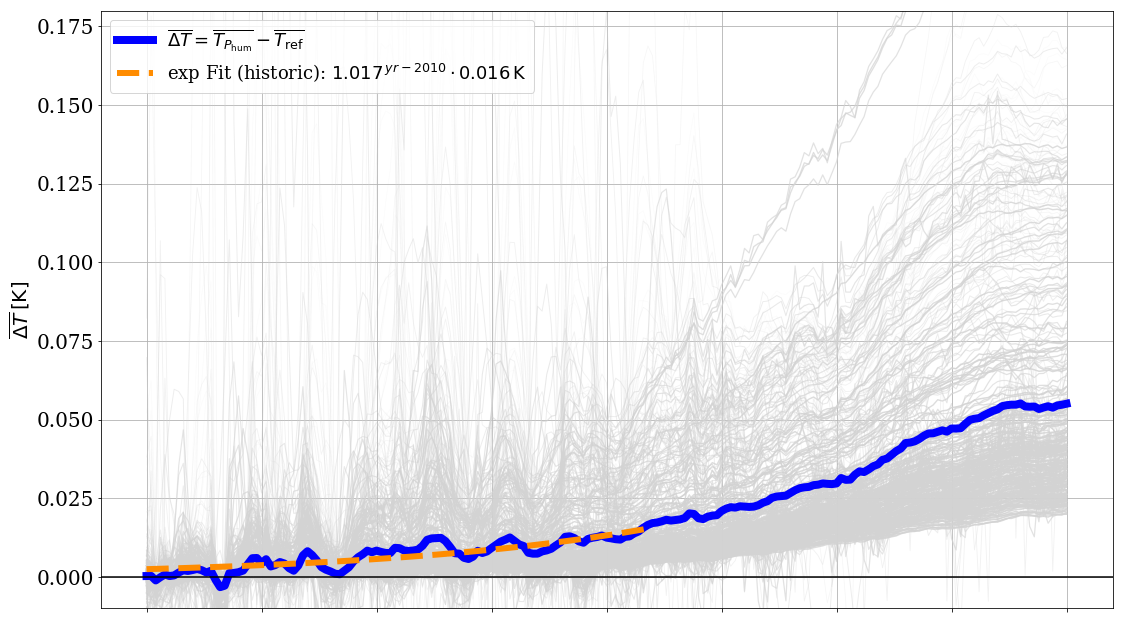

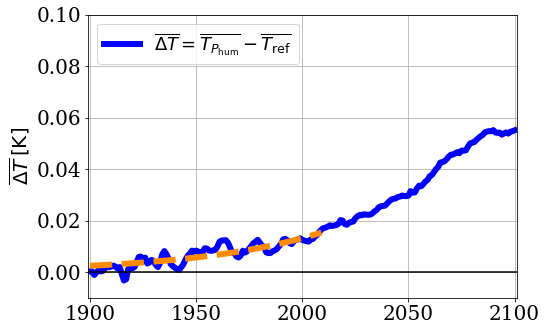

In [101]:
plot_name="T(t)_"+runname
plot_full(difference, double_years, p_mean, ref_mean, popt_hist, popt, diff)
plot_full(difference, double_years, p_mean, ref_mean, popt_hist, popt, diff, totalTemp=False)
plot_smaller(difference, double_years, popt_hist, popt, diff)

### FUTURE 2250

In [69]:
opt=""
single=False
SSP=False
fut2250=True
today=False

In [13]:
runname="hom_P-2Pr_rev"

folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
difference, double_years, p_mean, ref_mean, popt_hist, popt, diff = run(refname, runname)
get_sanity_checks(difference, popt, popt_hist, double_years)



(24, 16, 351)
(array([ 0.01974057,  0.0148586 ]), 0)
('That means:', 0.43701763677783856, ' K T-change per W/m^2 P_hum')
('2010:', array([ 0.01708529]))
('2010-2126:', array([ 0.12658085]))
('in year 2126: ', array([ 0.14366614]))


('will be saved as: ', 'T(t)_hom_P-2Pr_rev')
('will be saved as: ', 'T(t)_hom_P-2Pr_rev')


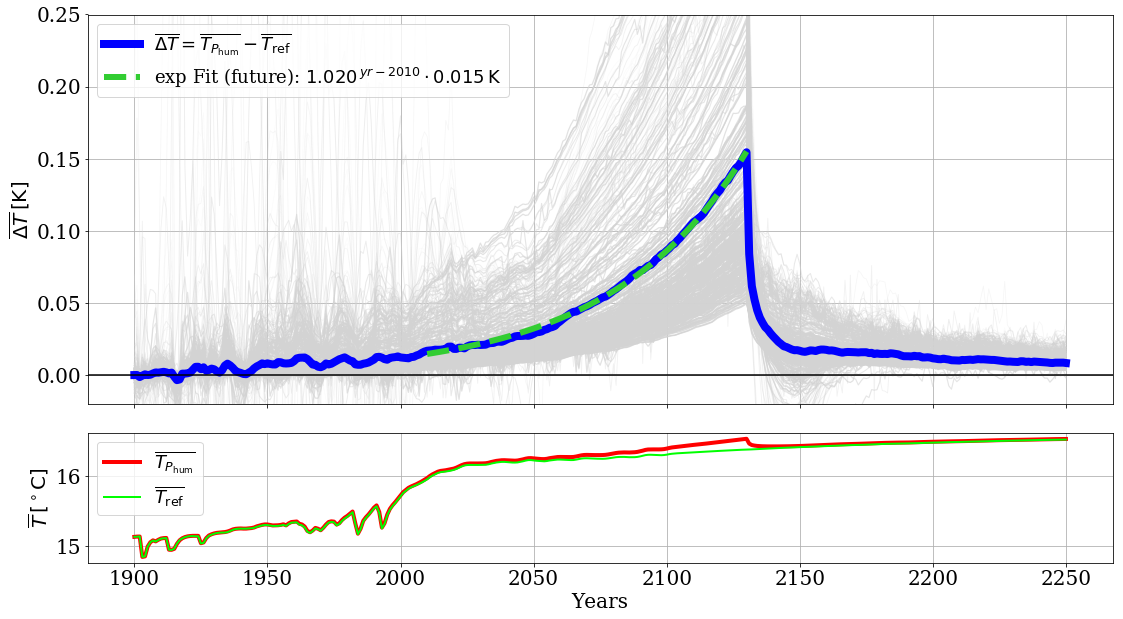

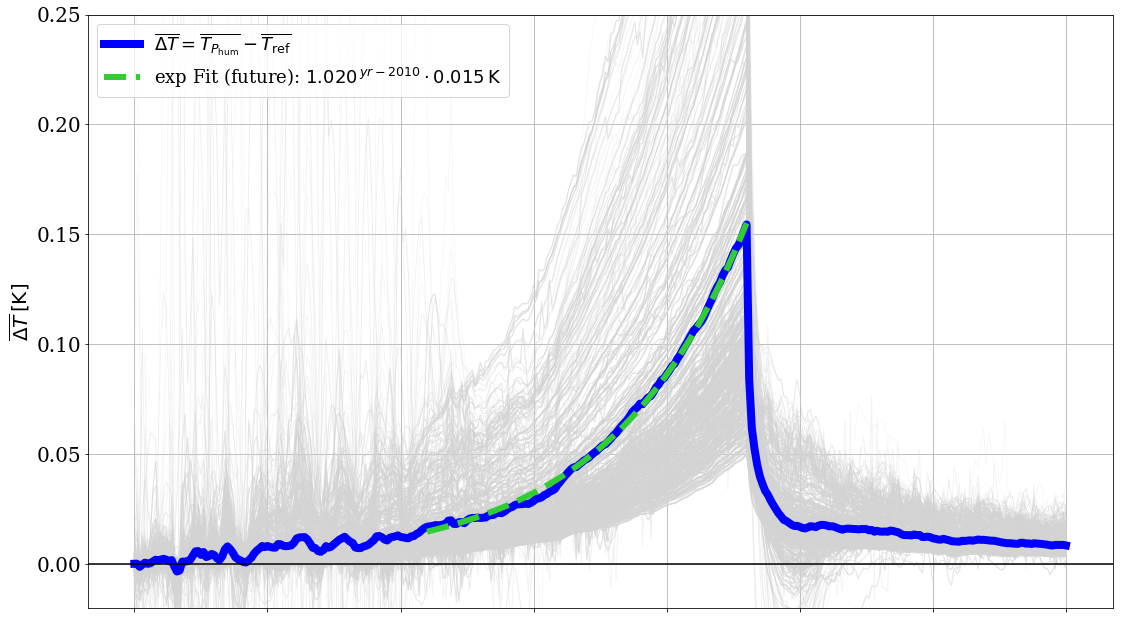

In [14]:
plot_name="T(t)_"+runname
plot_full(difference, double_years, p_mean, ref_mean, popt_hist, popt, diff)
plot_full(difference, double_years, p_mean, ref_mean, popt_hist, popt, diff, totalTemp=False)

In [16]:
print(difference[np.where(double_years==2130)])
print(difference[np.where(double_years==2250)])
print(difference[np.where(double_years==2250)]/difference[np.where(double_years==2130)])

[ 0.154564]
[ 0.00859654]
[ 0.05561797]


In [71]:
runname="hom_P-2Pr_const"

folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
difference, double_years, p_mean, ref_mean, diff= run(refname, runname)
print("Last Value in constant run: dT=", difference[-1], "dT(2250)-dT(2010)=", difference[-1]- difference[np.where(double_years==2010)[0][0]])
print("Transient T response (2130)=", difference[np.where(double_years==2130)[0][0]])



(24, 16, 351)
('Last Value in constant run: dT=', 0.18828849192864539, 'dT(2250)-dT(2010)=', 0.1712032006977804)
('Transient T response (2130)=', 0.15456400322744202)


In [72]:
plot_name="T(t)_"+runname
popt, popt_hist = plot_full(difference, double_years, p_mean, ref_mean, popt_hist, popt, diff)
get_sanity_checks(difference, popt, popt_hist, double_years)

plot_full(difference, double_years, p_mean, ref_mean, popt_hist, popt, diff, totalTemp=False)


TypeError: plot_full() takes at most 6 arguments (7 given)

In [84]:
runname="hom_P-2Pr_furthergrowth"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
difference, double_years, p_mean, ref_mean, popt_hist, popt, diff = run(refname, runname)
    

(24, 16, 351)
(array([ 0.01974092,  0.0148582 ]), 0)


('will be saved as: ', 'T(t)_hom_P-2Pr_furthergrowth')


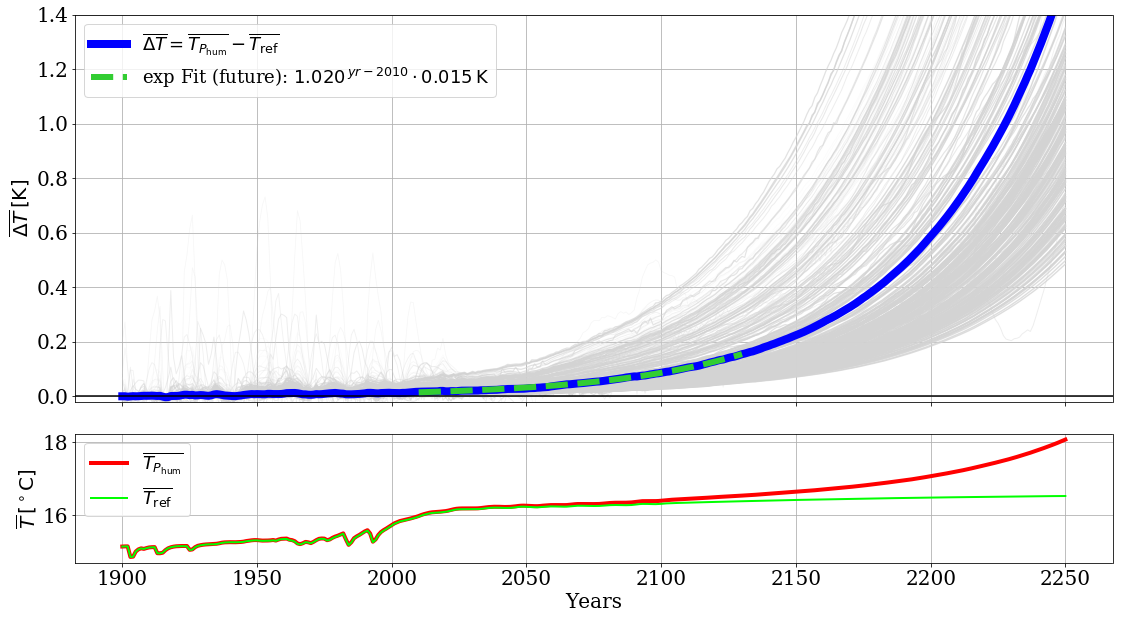

In [85]:
plot_name="T(t)_"+runname
plot_full(difference, double_years, p_mean, ref_mean, popt_hist, popt, diff)


In [86]:
mainfolder=climber_path+"cluster_results/data_Mai8files/"
reffolder=mainfolder
single=False
SSP=False
fut2250=True
today=False

refname="hom_REF_beyond2250"#"RESTandREF_fourth_sol2"#"RESTandREF_fourth"

folder_ref=reffolder+"c3beta_anthrHeat_"+refname+'/'

runname="hom_P-2Pr_furthergrowth_equ"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
difference, double_years, p_mean, ref_mean, popt_hist, popt, diff = run(refname, runname)
    

IOError: [Errno 2] No such file or directory: '/home/peter/PIK/climber/cluster_results/data_Mai8files/c3beta_anthrHeat_hom_REF_beyond2250/history_p2_short.nc'

## Apparently this did not work!

In [ ]:
plot_name="T(t)_"+runname
plot_full(difference, double_years, p_mean, ref_mean, popt_hist, popt, diff)
